# Seq2Seq models (Sequence-to-Sequence)

Sequence to sequence models are a variant of deep learning models that consists of an encoder and a decoder. They are used for problems that map an abitrarily long sequence to another arbitrarliy long sequence. For example, in machine translation, you convert a sequence of words in a source language to a sequence of words in a target language. Here we will see how we can use a seq2seq model to solve a machine translation task to convert English to German.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch11-Ch12-Sequence-to-Sequence-Learning-with-TF2/12.1_seq2seq_machine_translation_part_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>



In [1]:
import random
import tensorflow as tf
import numpy as np
import time
import json

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
 
# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.0


http://www.manythings.org/anki/
    
german-english

In [2]:
# Not setting this led to the following error
# _Derived_]RecvAsync is cancelled.   
# [[{{node gradient_tape/model_1/embedding_1/embedding_lookup/Reshape/_172}}]] [Op:__inference_train_function_31985]

%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


## Loading the data (Requires manual download)

Unfortunately, this dataset **must be manually downloaded** by clicking [this link](http://www.manythings.org/anki/deu-eng.zip). Then place the downloaded `deu-eng.zip` file in the `Ch11/data` folder before running the cell below.


In [3]:
import os
import requests
import zipfile

# Make sure the zip file has been downloaded
if not os.path.exists(os.path.join('data','deu-eng.zip')):
    raise FileNotFoundError(
        "Uh oh! Did you download the deu-eng.zip from http://www.manythings.org/anki/deu-eng.zip manually and place it in the Ch11/data folder?"
    )

else:
    if not os.path.exists(os.path.join('data', 'deu.txt')):
        with zipfile.ZipFile(os.path.join('data','deu-eng.zip'), 'r') as zip_ref:
            zip_ref.extractall('data')
    else:
        print("The extracted data already exists")

The extracted data already exists


## Reading the data

Data is in a single `.txt` file. It is a parallel corpus meaning there is a English sentence/phrase/paragraph and a corresponding German translation of it side-by-side. In the file, the source input and the translation are separated by a tab (i.e. tab-seperated file)

In [4]:
import pandas as pd

# Read the csv file
df = pd.read_csv(os.path.join('data', 'deu.txt'), delimiter='\t', header=None)
# Set column names
df.columns = ["EN", "DE", "Attribution"]
df = df[["EN", "DE"]]
print('df.shape = {}'.format(df.shape))

clean_inds = [i for i in range(len(df)) if b"\xc2" not in df.iloc[i]["DE"].encode("utf-8")]
df = df.iloc[clean_inds]

print('(clean) df.shape = {}'.format(df.shape))

df.shape = (227080, 2)
(clean) df.shape = (226553, 2)


In [5]:
df.head()

,EN,DE
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


In [6]:
df.tail()

,EN,DE
227073,Death is something that we're often discourage...,"Wir werden oft davon abgehalten, über den Tod ..."
227074,"At a moment when our economy is growing, our b...","In einem Moment, in dem unsere Wirtschaft wäch..."
227075,Even if some sentences by non-native speakers ...,Auch wenn Sätze von Nichtmuttersprachlern mitu...
227076,If someone who doesn't know your background sa...,"Wenn jemand, der deine Herkunft nicht kennt, s..."
227077,If someone who doesn't know your background sa...,"Wenn jemand Fremdes dir sagt, dass du dich wie..."


## Use a smaller sample for computational speed

There are more than 220000 samples in the original dataset. We will be using a smaller set of 50000 for our dataset. 

In [7]:
n_samples = 50000
df = df.sample(n=n_samples, random_state=random_seed)

## Introducing the `SOS` and `EOS` tokens (Decoder)

We will add these special tokens to the translated targets. `sos` indicates the start of the sentence and `eos` marks the end of the sentence. 

E.g. `Grüß Gott!` becomes `sos Grüß Gott! eos`

In [8]:
start_token = 'sos'
end_token = 'eos'

df["DE"] = start_token + ' ' + df["DE"] + ' ' + end_token

## Splitting training/validation/testing data

We will be creating three datasets by sampling randomly (without replacement);

* Test dataset - 5000 samples
* Validation dataset - 5000 samples
* Training dataset - 40000 samples

In [9]:
# Randomly sample 5000 examples from the total 50000 randomly
test_df = df.sample(n=int(n_samples/10), random_state=random_seed)
# Randomly sample 5000 examples from the total 50000 randomly
valid_df = df.loc[~df.index.isin(test_df.index)].sample(n=int(n_samples/10), random_state=random_seed)
# Assign the rest to training data
train_df = df.loc[~(df.index.isin(test_df.index) | df.index.isin(valid_df.index))]

print('test_df.shape = {}'.format(test_df.shape))
print('valid_df.shape = {}'.format(valid_df.shape))
print('train_df.shape = {}'.format(train_df.shape))

test_df.shape = (5000, 2)
valid_df.shape = (5000, 2)
train_df.shape = (40000, 2)


## Analysing the vocabulary sizes (English and German)

Calculate the vocabulary size. We will only consider the words that appear at least 10 times in the corpus.

In [10]:
from collections import Counter

# Create a flattened list from English words
en_words = train_df["EN"].str.split().sum()
# Create a flattened list of German words
de_words = train_df["DE"].str.split().sum()

# Get the vocabulary size of words appearing more than or equal to 10 times
n=10

def get_vocabulary_size_greater_than(words, n, verbose=True):
    
    """ Get the vocabulary size above a certain threshold """
    
    # Generate a counter object i.e. dict word -> frequency
    counter = Counter(words)
    
    # Create a pandas series from the counter, then sort most frequent to least
    freq_df = pd.Series(list(counter.values()), index=list(counter.keys())).sort_values(ascending=False)
    
    if verbose:
        # Print most common words
        print(freq_df.head(n=10))

    # Count of words >= n frequent    
    n_vocab = (freq_df>=n).sum()
    
    if verbose:
        print("\nVocabulary size (>={} frequent): {}".format(n, n_vocab))
        
    return n_vocab

print("English corpus")
print('='*50)
en_vocab = get_vocabulary_size_greater_than(en_words, n)

print("\nGerman corpus")
print('='*50)
de_vocab = get_vocabulary_size_greater_than(de_words, n)

English corpus
Tom    9516
to     8722
I      8407
the    6891
you    6077
a      5823
is     4322
in     2741
of     2536
was    2380
dtype: int64

Vocabulary size (>=10 frequent): 2234

German corpus
sos      40000
eos      40000
Tom      10046
Ich       7746
ist       4698
nicht     4550
zu        3589
Sie       3448
du        3074
das       2844
dtype: int64

Vocabulary size (>=10 frequent): 2481


## Analysing the sequence length (English and German)

Here we compute the sequence length of the sequences in the English and German corpora. To ignore the outliers, we only consider data between the 1% and 99% quantiles.

In [11]:
def print_sequence_length(str_ser):
    
    """ Print the summary stats of the sequence length """
    
    # Create a pd.Series, which contain the sequence length for each review
    seq_length_ser = str_ser.str.split(' ').str.len()

    # Get the median as well as summary statistics of the sequence length
    print("\nSome summary statistics")
    print("Median length: {}\n".format(seq_length_ser.median()))
    print(seq_length_ser.describe())
    
    # Get the quantiles at given marks
    print("\nComputing the statistics between the 1% and 99% quantiles (to ignore outliers)")
    p_01 = seq_length_ser.quantile(0.01)
    p_99 = seq_length_ser.quantile(0.99)
    
    # Print the summary stats of the data between the defined quantlies
    print(seq_length_ser[(seq_length_ser >= p_01) & (seq_length_ser < p_99)].describe())

print("English corpus")
print('='*50)
print_sequence_length(train_df["EN"])

print("\nGerman corpus")
print('='*50)
print_sequence_length(train_df["DE"])

English corpus

Some summary statistics
Median length: 6.0

count    40000.00000
mean         6.34485
std          2.60440
min          1.00000
25%          5.00000
50%          6.00000
75%          8.00000
max         44.00000
Name: EN, dtype: float64

Computing the statistics between the 1% and 99% quantiles (to ignore outliers)
count    39515.000000
mean         6.218272
std          2.317611
min          2.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         14.000000
Name: EN, dtype: float64

German corpus

Some summary statistics
Median length: 8.0

count    40000.000000
mean         8.374325
std          2.600928
min          3.000000
25%          7.000000
50%          8.000000
75%         10.000000
max         46.000000
Name: DE, dtype: float64

Computing the statistics between the 1% and 99% quantiles (to ignore outliers)
count    39173.000000
mean         8.282797
std          2.280142
min          5.000000
25%          7.000000
50%          8.

## Printing the vocabulary size and sequence length

In [12]:
print("EN vocabulary size: {}".format(en_vocab))
print("DE vocabulary size: {}".format(de_vocab))

# Define sequence lengths with some extra space for longer sequences
en_seq_length = 19
de_seq_length = 21

print("EN max sequence length: {}".format(en_seq_length))
print("DE max sequence length: {}".format(de_seq_length))

EN vocabulary size: 2234
DE vocabulary size: 2481
EN max sequence length: 19
DE max sequence length: 21


## Defining the Seq2Seq model

Here we define an encoder decoder model to translate between English and German. We will be using a bidirectional encoder and a standard decoder. The model will use Gated Recurrent Unit (GRU) as the recurrent component. The encoder and the decoder has their own `TextVectorization` layers as they use two different languages. 

## Seq2Seq model with Attention

Here we will define a sequence-to-sequence model with attention. Specifically we will be using [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf). Bahdanau attention enables the decoder to look at all of the history of the encoder outputs, then select and mix various outputs for every decoding step as required. The mixing propotions are jointly learned during the training, using trainable weights.

### Defining a layer for Bahdanau Attention

In [14]:
# Section 12.1

import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class DecoderRNNAttentionWrapper(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, cell, units, **kwargs):
        self._cell = cell
        self.units = units
        super().__init__(**kwargs)

    def build(self, input_shape):

        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.
        # Weight matrices of the attention layer
        # W_a is a [s, self.units] sized matrix
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], self.units)),
                                   initializer='uniform',
                                   trainable=True)
        # U_a is a [h, self.units] sized matrix
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((self._cell.units, self.units)),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((self.units, 1)),
                                   initializer='uniform',
                                   trainable=True)
        
    
    # Code listing 12.1
    def call(self, inputs, initial_state, training=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        
        encoder_outputs, decoder_inputs = inputs

        def _step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * de_in_dim)
            states: [(batchsize * de_latent_dim)]
            """
            
            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg
            
            encoder_full_seq = states[-1]
            W_a, U_a, V_a = states[-4], states[-3], states[-2]
            #_cell_fn = states[-5]
            #_cell_fn = states[-1]
            
            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_h = K.dot(encoder_full_seq, W_a)

            """ Computing hj.Ua """                        
            U_a_dot_s = K.expand_dims(K.dot(states[0], U_a), 1)  # <= batch_size, 1, latent_dim
                      
            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Wh_plus_Us = K.tanh(W_a_dot_h + U_a_dot_s)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Wh_plus_Us, V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            """ Computing c_i using e_i and h_j (for all j) """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(e_i, -1), axis=1)
            
            """ Concat the current input and c_i and feed it to the RNN """
            s, states = self._cell(K.concatenate([inputs, c_i], axis=-1), states)              
        
            return (s, e_i), states

        """ Computing outputs """
        
        last_out, attn_outputs, _ = K.rnn(
            _step, decoder_inputs, [initial_state], constants=[self.W_a, self.U_a, self.V_a, encoder_outputs]#, self._cell_fn]
        )

        # attn_out => (batch_size, de_seq_len, de_hidden_size)
        # attn_energy => (batch_size, de_seq_len, en_seq_len)
        attn_out, attn_energy = attn_outputs        

        return attn_out, attn_energy

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]
    
    def get_config(self):
        return {"units": self.units, "_cell": self._cell}
    

### Defining the full model

In [18]:
# Section 12.1
import tensorflow.keras.backend as K
K.clear_session()

# Code listing 12.3
def get_vectorizer(list_of_strings, n_vocab, max_length=None, return_vocabulary=True, name=None):
    
    """ Return a text vectorization layer or a model """
    
    # Definie an input layer that takes a list of strings (or an array of strings)
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='encoder_input')
    
    # When defining the vocab size, we'd add two for special tokens '' (Padding) and '[UNK]' (Oov tokens)
    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=n_vocab+2,
        output_mode='int',
        output_sequence_length=max_length,                
    )
    
    # Fit the vectorizer layer on the data
    vectorize_layer.adapt(list_of_strings)
        
    # Get the token IDs
    vectorized_out = vectorize_layer(inp)
        
    if not return_vocabulary: 
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name)    
    else:
        # Returns the vocabulary in addition to the model
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name), vectorize_layer.get_vocabulary()
    
# Code listing 12.4        
def get_encoder_with_attention(n_vocab, vectorizer):
    """ Define the encoder of the seq2seq model"""
    
    # The input is (None,1) shaped and accepts an array of strings
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input')

    # Vectorize the data (assign token IDs)
    vectorized_out = vectorizer(inp)
    
    # Define an embedding layer to convert IDs to word vectors
    emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='e_embedding')
    # Get the embeddings of the token IDs
    emb_out = emb_layer(vectorized_out)
    
    # Define a bidirectional GRU layer
    # Encoder looks at the english text (i.e. the input) both backwards and forward
    # this leads to better performance
    gru_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, return_state=True, name='e_gru'), 
        name='e_bidirectional_gru'
    )
    
    # Get the output of the gru layer
    gru_out_sequence, gru_fwd_out, gru_bwd_out = gru_layer(emb_out)
    # Define the encoder model
    encoder = tf.keras.models.Model(inputs=inp, outputs=[gru_fwd_out, gru_bwd_out, gru_out_sequence], name='encoder')
        
    # We are also returning the final state of the encoder as that
    # is passed as the initial state to the decoder
    return encoder

# Code listing 12.2
def get_final_seq2seq_model_with_attention(n_vocab, encoder, vectorizer):
    """ Define the final encoder-decoder model """
    
    e_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input_final')    
    fwd_state, bwd_state, en_states = encoder(e_inp)
    
    # The input is (None,1) shaped and accepts an array of strings
    # This input layer is used to train the seq2seq model with teacher-forcing
    # we feed the German sequence as the input and ask the model to predict 
    # it with the words offset by 1 (i.e. next word)
    d_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_input')
    
    # Vectorize the data (assign token IDs)
    d_vectorized_out = vectorizer(d_inp)
    
    # Define an embedding layer to convert IDs to word vectors
    # Note that this is a different embedding layer to the encoder's embedding layer
    d_emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='d_embedding')
    
    # Get the embeddings of the token IDs
    d_emb_out = d_emb_layer(d_vectorized_out)
    
    # Define a GRU layer
    # Unlike the encoder, we cannot define a bidirectional GRU for the decoder 
    # Get the output of the gru layer
    d_init_state = tf.keras.layers.Concatenate(axis=-1)([fwd_state, bwd_state])
    
    gru_cell = tf.keras.layers.GRUCell(256)
    attn_out, _  = DecoderRNNAttentionWrapper(cell=gru_cell, units=512, name="d_attention")([en_states, d_emb_out], initial_state=d_init_state)

    # Define an intermediate dense layer
    d_dense_layer_1 = tf.keras.layers.Dense(512, activation='relu', name='d_dense_1')
    d_dense1_out = d_dense_layer_1(attn_out)
    
    # The final prediction layer with softmax
    d_final_layer = tf.keras.layers.Dense(n_vocab+2, activation='softmax', name='d_dense_final')
    d_final_out = d_final_layer(d_dense1_out)
    
    # Define the full model
    seq2seq = tf.keras.models.Model(inputs=[e_inp, d_inp], outputs=d_final_out, name='final_seq2seq_with_attention')
    
    return seq2seq

# Get the English vectorizer/vocabulary
en_vectorizer, en_vocabulary = get_vectorizer(np.array(train_df["EN"].tolist()), en_vocab, max_length=en_seq_length, name='e_vectorizer')
# Get the German vectorizer/vocabulary
de_vectorizer, de_vocabulary = get_vectorizer(np.array(train_df["DE"].tolist()), de_vocab, max_length=de_seq_length-1, name='d_vectorizer')

# Define the final model with attention
encoder = get_encoder_with_attention(en_vocab, en_vectorizer)
final_model_with_attention = get_final_seq2seq_model_with_attention(de_vocab, encoder, de_vectorizer)


### Compiling the model

In [19]:
# Section 12.1

# Compile the model
final_model_with_attention.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
final_model_with_attention.summary()

Model: "final_seq2seq_with_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 e_input_final (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 d_input (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        484352      ['e_input_final[0][0]']          
                                 (None, 128),                                                     
                                 (None, 19, 256)]                                                 
                                                                       

## Evaluating MT models - BLEU metric

In machine translation, a popular choice for assessing performance is the BiLingual Evaluation Understudy (BLEU) metric. Word-to-word accuracy does not reflect the true performance of these models as there can be different ways the same phrase can be translated to. BLEU can take into account such multiple translations when computing the final score. Furthermore, BLEU is superior because it measures precision at multiple n-gram scales between the actual and predicted translations.

The implementation is inspired by: https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py

### Defining the BLEU metric

Below we define a `BLEUMetric` object that can be used to compute the performance of the model.

In [20]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from bleu import compute_bleu

class BLEUMetric(object):
    
    def __init__(self, vocabulary, name='perplexity', **kwargs):
      """ Computes the BLEU score (Metric for machine translation) """
      super().__init__()
      self.vocab = vocabulary
      self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token="[KNU]", invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = self.id_to_token_layer(pred_argmax)
        real_tokens = self.id_to_token_layer(real)
        
        def clean_text(tokens):
            
            """ Clean padding and [SOS]/[EOS] tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "eos.*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode(
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else '[UNK]' for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

### Using the BLEU metric

Below you can see BLEU being used to computer the similarity between a translation (predicted) and reference (true target).

In [21]:
translation = [['[UNK]', '[UNK]', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]

bleu1, _, _, _, _, _ = compute_bleu(reference, translation)

translation = [['[UNK]', 'einmal', 'mÃssen', '[UNK]', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]


bleu2, _, _, _, _, _ = compute_bleu(reference, translation)

print("BLEU score with longer correctly predicte phrases: {}".format(bleu1))
print("BLEU score without longer correctly predicte phrases: {}".format(bleu2))

BLEU score with longer correctly predicte phrases: 0.7598356856515925
BLEU score without longer correctly predicte phrases: 0.537284965911771


## Train the model with attention

We will train the model using a custom loop as we want to incorporate BLEU as a metric in our training. We will follow the following procedure;

* Each epoch,
  * Shuffle the training data
  * Train our model on all the training data (in batches)
  * Evaluate the model on validation data
* Finally, evaluate the model on test data

In [22]:
import time

epochs = 5
batch_size = 128


def prepare_data(train_df, valid_df, test_df):
    """ Create a data dictionary from the dataframes containing data """
    
    data_dict = {}
    for label, df in zip(['train', 'valid', 'test'], [train_df, valid_df, test_df]):
        en_inputs = np.array(df["EN"].tolist())
        de_inputs = np.array(df["DE"].str.rsplit(n=1, expand=True).iloc[:,0].tolist())
        de_labels = np.array(df["DE"].str.split(n=1, expand=True).iloc[:,1].tolist())
        data_dict[label] = {'encoder_inputs': en_inputs, 'decoder_inputs': de_inputs, 'decoder_labels': de_labels}
    
    return data_dict


def shuffle_data(en_inputs, de_inputs, de_labels, shuffle_inds=None): 
    """ Shuffle the data randomly (but all of inputs and labels at ones)"""
        
    if shuffle_inds is None:
        # If shuffle_inds are not passed create a shuffling automatically
        shuffle_inds = np.random.permutation(np.arange(en_inputs.shape[0]))
    else:
        # Shuffle the provided shuffle_inds
        shuffle_inds = np.random.permutation(shuffle_inds)
    
    # Return shuffled data
    return (en_inputs[shuffle_inds], de_inputs[shuffle_inds], de_labels[shuffle_inds]), shuffle_inds


def evaluate_model(model, vectorizer, en_inputs_raw, de_inputs_raw, de_labels_raw, batch_size):
    """ Evaluate the model on various metrics such as loss, accuracy and BLEU """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)
    
    loss_log, accuracy_log, bleu_log = [], [], []
    # Get the number of batches
    n_batches = en_inputs_raw.shape[0]//batch_size
    print(" ", end='\r')

    # Evaluate one batch at a time
    for i in range(n_batches):
        # Status update
        print("Evaluating batch {}/{}".format(i+1, n_batches), end='\r')

        # Get the inputs and targers
        x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
        y = vectorizer(de_labels_raw[i*batch_size:(i+1)*batch_size])

        # Get the evaluation metrics
        loss, accuracy = model.evaluate(x, y, verbose=0)
        # Get the predictions to compute BLEU
        pred_y = model.predict(x, verbose=0)

        # Update logs
        loss_log.append(loss)
        accuracy_log.append(accuracy)
        bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
    
    return np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)
    
        
def train_model(model, vectorizer, train_df, valid_df, test_df, epochs, batch_size):
    """ Training the model and evaluating on validation/test sets """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)

    # Define the data
    data_dict = prepare_data(train_df, valid_df, test_df)

    shuffle_inds = None
    
    
    for epoch in range(epochs):

        # Reset metric logs every epoch
        bleu_log = []
        accuracy_log = []
        loss_log = []

        # =================================================================== #
        #                         Train Phase                                 #
        # =================================================================== #

        # Shuffle data at the beginning of every epoch
        (en_inputs_raw,de_inputs_raw,de_labels_raw), shuffle_inds  = shuffle_data(
            data_dict['train']['encoder_inputs'],
            data_dict['train']['decoder_inputs'],
            data_dict['train']['decoder_labels'],
            shuffle_inds
        )

        # Get the number of training batches
        n_train_batches = en_inputs_raw.shape[0]//batch_size

        # Train one batch at a time
        for i in range(n_train_batches):
            # Status update
            print("Training batch {}/{}".format(i+1, n_train_batches), end='\r')

            # Get a batch of inputs (english and german sequences)
            x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
            # Get a batch of targets (german sequences offset by 1)
            y = vectorizer(de_labels_raw[i*batch_size:(i+1)*batch_size])

            # Train for a single step
            model.train_on_batch(x, y)        
            # Evaluate the model to get the metrics
            loss, accuracy = model.evaluate(x, y, verbose=0)
            # Get the final prediction to compute BLEU
            pred_y = model.predict(x, verbose=0)

            # Update the epoch's log records of the metrics
            loss_log.append(loss)
            accuracy_log.append(accuracy)
            bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))

        # =================================================================== #
        #                      Validation Phase                               #
        # =================================================================== #
        
        val_en_inputs = data_dict['valid']['encoder_inputs']
        val_de_inputs = data_dict['valid']['decoder_inputs']
        val_de_labels = data_dict['valid']['decoder_labels']
            
        val_loss, val_accuracy, val_bleu = evaluate_model(
            model, vectorizer, val_en_inputs, val_de_inputs, val_de_labels, batch_size
        )
            
        # Print the evaluation metrics of each epoch
        print("\nEpoch {}/{}".format(epoch+1, epochs))
        print("\t(train) loss: {} - accuracy: {} - bleu: {}".format(np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)))
        print("\t(valid) loss: {} - accuracy: {} - bleu: {}".format(val_loss, val_accuracy, val_bleu))
    
    # =================================================================== #
    #                      Test Phase                                     #
    # =================================================================== #    
    
    test_en_inputs = data_dict['test']['encoder_inputs']
    test_de_inputs = data_dict['test']['decoder_inputs']
    test_de_labels = data_dict['test']['decoder_labels']
            
    test_loss, test_accuracy, test_bleu = evaluate_model(
            model, vectorizer, test_en_inputs, test_de_inputs, test_de_labels, batch_size
    )
    
    print("\n(test) loss: {} - accuracy: {} - bleu: {}".format(test_loss, test_accuracy, test_bleu))


In [23]:
# Section 12.1

epochs = 5
batch_size = 128

t1 = time.time()
train_model(final_model_with_attention, de_vectorizer, train_df, valid_df, test_df, epochs, batch_size)
t2 = time.time()

print("\nIt took {} seconds to complete the training".format(t2-t1))

/home/thushv89/anaconda3/envs/manning.tf2.9/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


2022-07-27 09:53:07.627043: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_43/output/_17'
2022-07-27 09:53:08.225133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


Evaluating batch 39/39
Epoch 1/5
	(train) loss: 2.0752783627846303 - accuracy: 0.6888859655994636 - bleu: 0.0005681653066940263
	(valid) loss: 1.6008197925029657 - accuracy: 0.7371093691923679 - bleu: 0.002460996513969811
Evaluating batch 39/39
Epoch 2/5
	(train) loss: 1.447308545693373 - accuracy: 0.752675531575313 - bleu: 0.01417632973594322
	(valid) loss: 1.2879543090477967 - accuracy: 0.7710636991720933 - bleu: 0.03796219856459943
Evaluating batch 39/39
Epoch 3/5
	(train) loss: 1.1563816941701448 - accuracy: 0.78665113926698 - bleu: 0.07015363789345219
	(valid) loss: 1.0753497389646678 - accuracy: 0.799469150029696 - bleu: 0.09516419522150918
Evaluating batch 39/39
Epoch 4/5
	(train) loss: 0.9301754478842784 - accuracy: 0.8162735373927996 - bleu: 0.13895571322243908
	(valid) loss: 0.9184120373848157 - accuracy: 0.8207632211538461 - bleu: 0.1481616295578806
Evaluating batch 39/39
Epoch 5/5
	(train) loss: 0.7694130809261248 - accuracy: 0.8390787776846153 - bleu: 0.20172496847209867
	

## Save the trained model and vocabulary

In [24]:
# Section 12.1

## Save the model
os.makedirs('models', exist_ok=True)
tf.keras.models.save_model(final_model_with_attention, os.path.join('models', 'seq2seq_attention'))

# Save the vocabulary
import json
os.makedirs(os.path.join('models', 'seq2seq_attention_vocab'), exist_ok=True)
with open(os.path.join('models', 'seq2seq_attention_vocab', 'de_vocab.json'), 'w') as f:
    json.dump(de_vocabulary, f)
    
with open(os.path.join('models', 'seq2seq_attention_vocab', 'en_vocab.json'), 'w') as f:
    json.dump(en_vocabulary, f)

INFO:tensorflow:Assets written to: models/seq2seq_attention/assets


INFO:tensorflow:Assets written to: models/seq2seq_attention/assets


## Defining the model for visualizing attention patterns

As we did to generate translation, we have to define a new model using the trained weights of the trained model to visualize attention patterns.

In [25]:
# Section 12.2

import tensorflow.keras.backend as K
K.clear_session()

# Code listing 12.5
def attention_visualizer(save_path):
    """ Define the attention visualizer model """
    
    # Load the model
    model = tf.keras.models.load_model(save_path)
    
    # Define encoder input the model and get the final outputs of the encoder
    e_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input_final')    
    en_model = model.get_layer("encoder")
    fwd_state, bwd_state, en_states = en_model(e_inp)
    
    # Get the encoder vectorizer
    e_vec_out = en_model.get_layer("e_vectorizer")(e_inp)
    
    # Define decoder input
    d_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_infer_input')    
    
    # Get the decoder vectorizer and get the output
    d_vec_layer = model.get_layer('d_vectorizer')
    d_vec_out = d_vec_layer(d_inp)
    
    # Get the embedding output
    d_emb_out = model.get_layer('d_embedding')(d_vec_out)
        
    # Get the GRU output
    d_attn_layer = model.get_layer("d_attention")
            
    # The initial state for the decoder
    d_init_state = tf.keras.layers.Concatenate(axis=-1)([fwd_state, bwd_state])
    # Define the attention layer and the outputs
    attn_out, attn_states = d_attn_layer([en_states, d_emb_out], initial_state=d_init_state) 
    
    # Get the interim dense outptu and the final output
    d_dense1_out = model.get_layer("d_dense_1")(attn_out) 
    
    d_final_out = model.get_layer("d_dense_final")(d_dense1_out) 
    
    # Here we define the final model, to visualize attention patterns,
    # we are interested in the attn_states output. We will also need the
    # vectorized token IDs to annotate the visualization 
    visualizer_model = tf.keras.models.Model(
        inputs=[e_inp, d_inp], 
        outputs=[d_final_out, attn_states, e_vec_out, d_vec_out]
    )
    
    return visualizer_model

def get_vocabularies(save_dir):
    """ Load the vocabularies """
    
    with open(os.path.join(save_dir, 'en_vocab.json'), 'r') as f:
        en_vocabulary = json.load(f)
        
    with open(os.path.join(save_dir, 'de_vocab.json'), 'r') as f:
        de_vocabulary = json.load(f)
        
    return en_vocabulary, de_vocabulary

print("Loading vocabularies")
en_vocabulary, de_vocabulary = get_vocabularies(os.path.join('models', 'seq2seq_attention_vocab'))

print("Loading weights and generating the inference model")
visualizer_model = attention_visualizer(os.path.join('models', 'seq2seq_attention'))
print("\tDone")

Loading vocabularies
Loading weights and generating the inference model


2022-07-27 10:00:33.275676: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-07-27 10:00:33.304849: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-07-27 10:00:33.351327: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-07-27 10:00:33.460614: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-07-27 10:00:33.584098: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but 

	Done


## Visualizing attention patterns

Let's visualize and save the attention patterns.

Input: Tom rolled up the poster and put it into a cardboard tube.
Input: Tom is the only man in the world that can pull this off.
Input: Tom said that he was the one responsible for what had happened.
Input: I ought to have enough money saved up to buy a car by Christmas.
Input: I still think it's unlikely that we'll find any evidence to prove Tom's guilt.
Input: I never wanted to leave you, but I had no choice.
Input: Tom was with a girl, but I didn't manage to see who it was.
Input: I doubt that Tom has ever read a book from cover to cover in his life.
Input: Tom called Mary up and asked her what her schedule was.


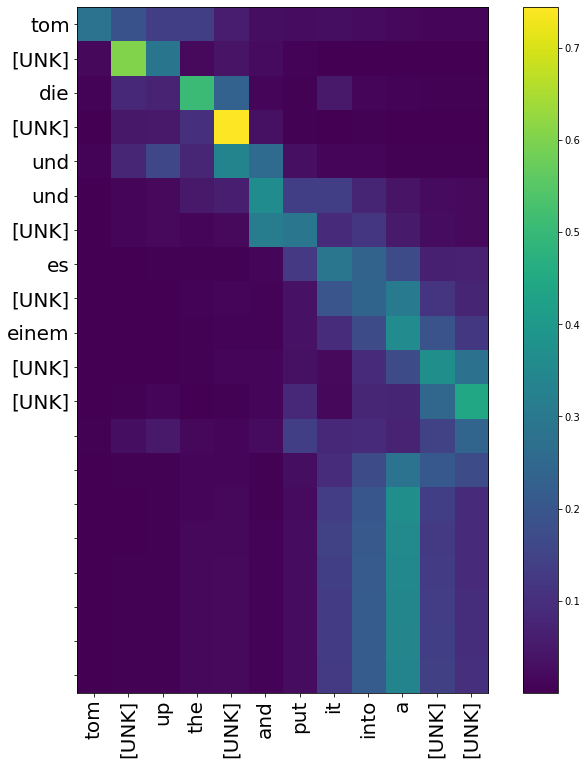

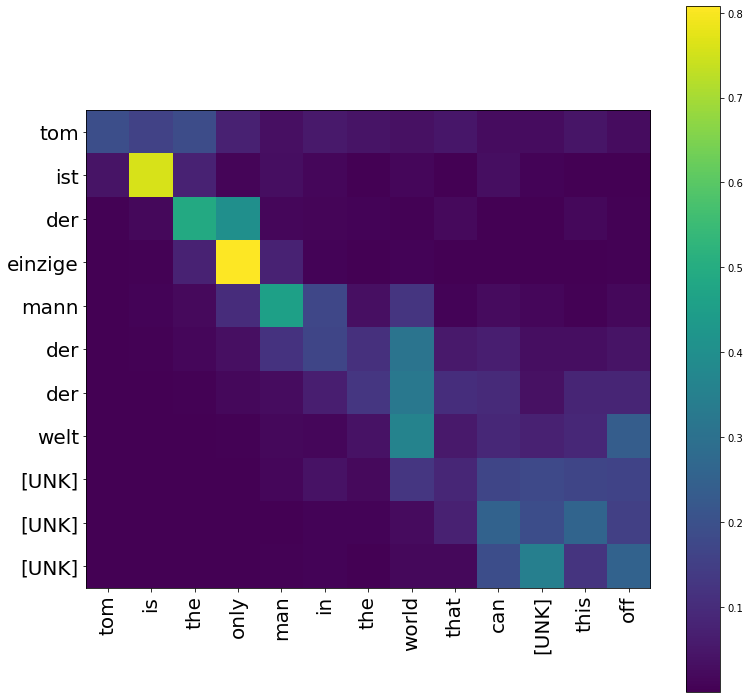

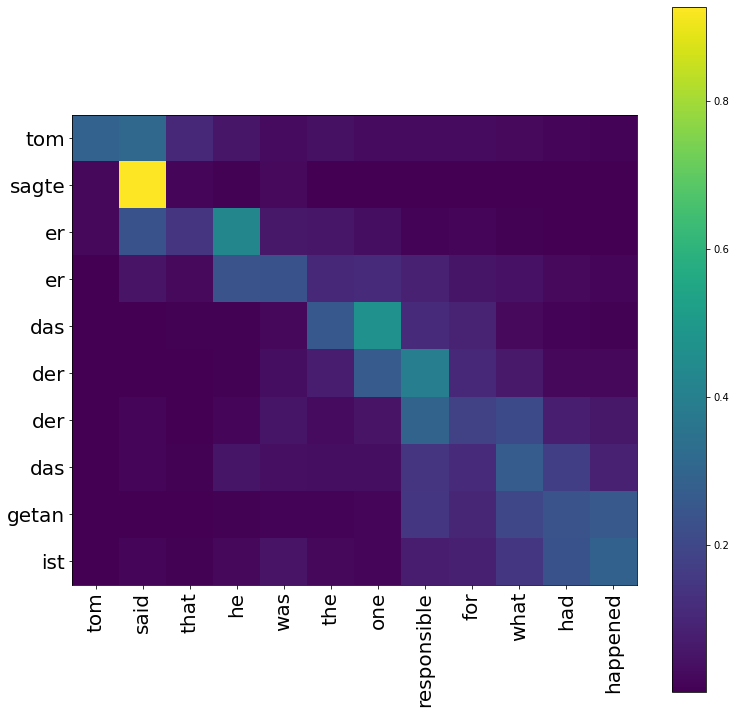

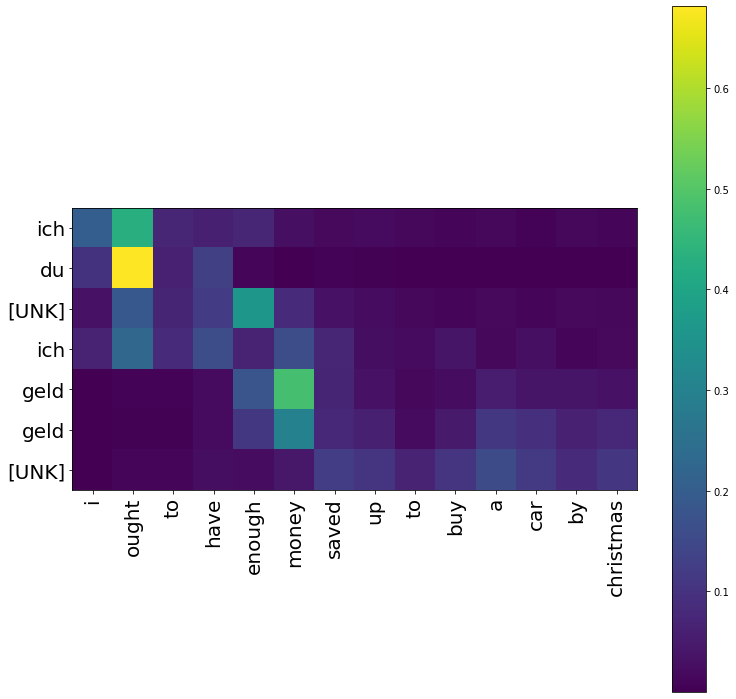

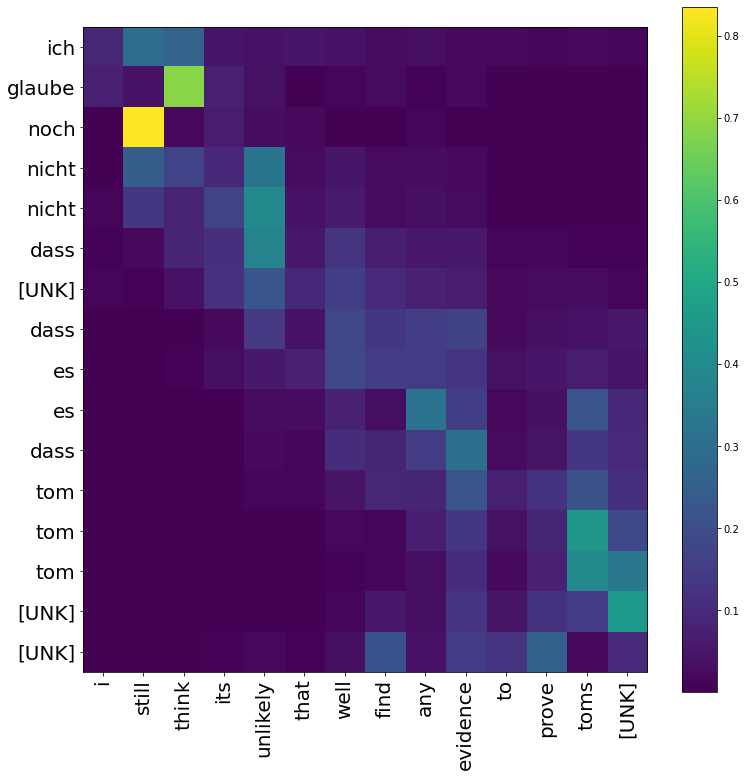

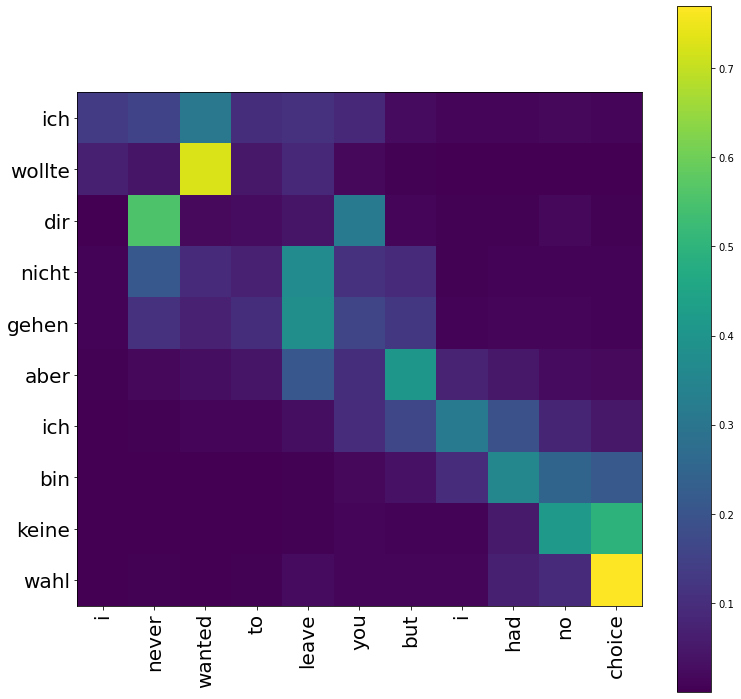

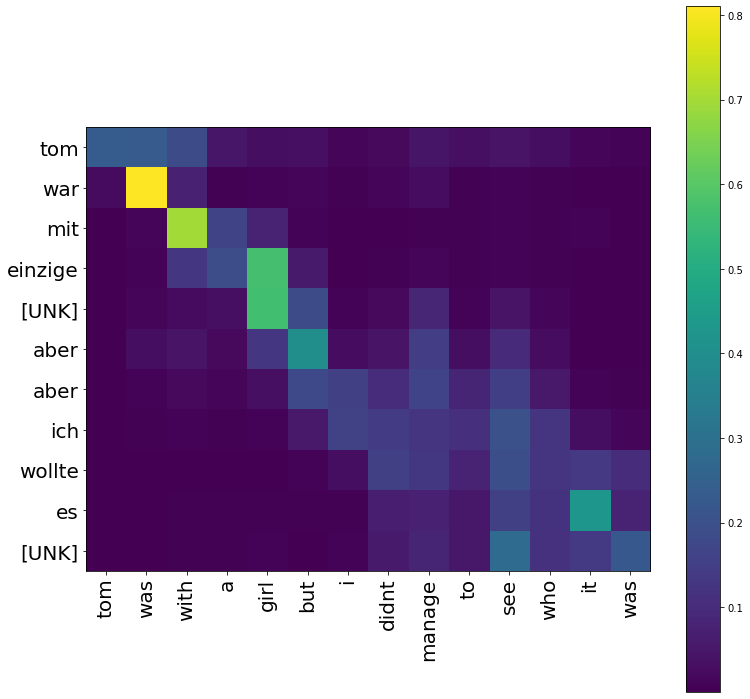

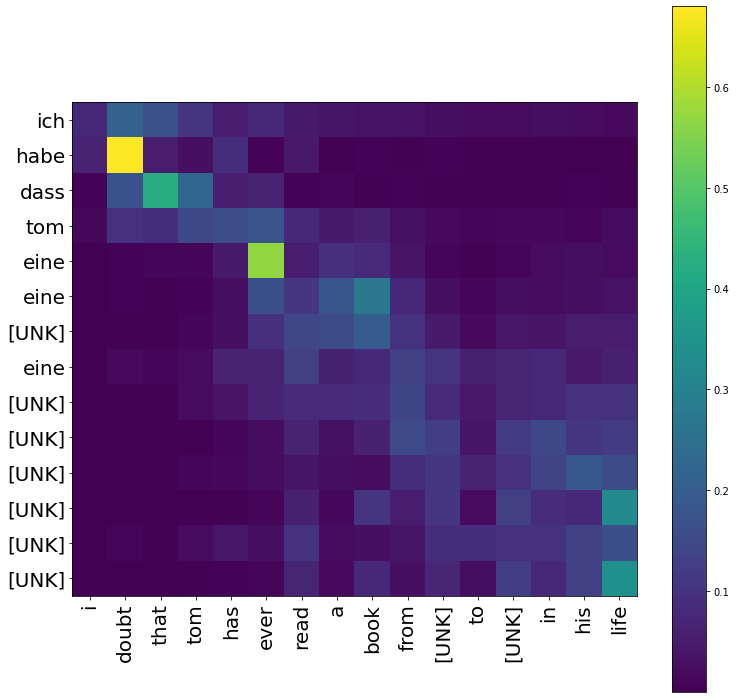

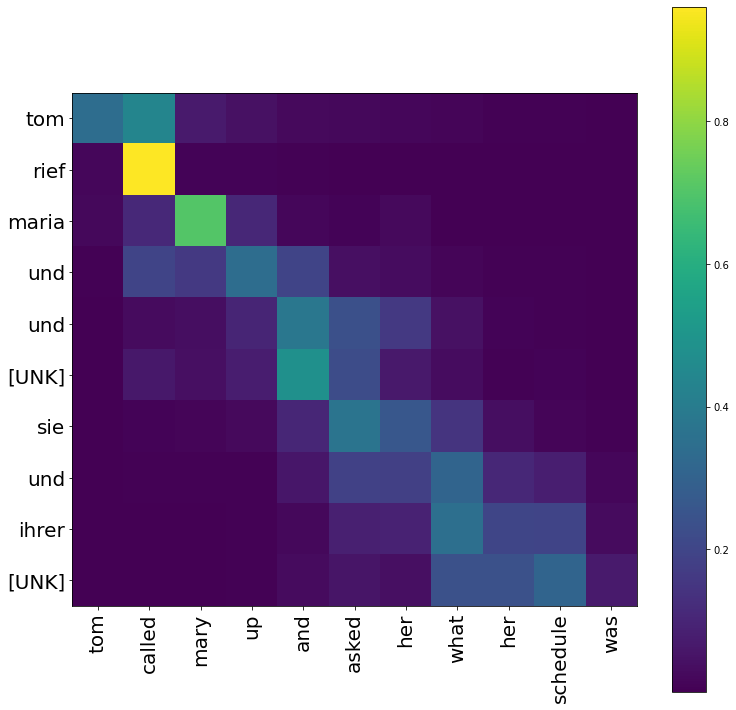

In [30]:
# Section 12.2

import matplotlib.pyplot as plt
%matplotlib inline

# Code listing 12.6
def visualize_attention(visualizer_model, en_vocabulary, de_vocabulary, sample_en_text, sample_de_text, fig_savepath):
    """ Visualize the attention patterns """
    
    # Print the input sentence
    print("Input: {}".format(sample_en_text))
    
    # Get the model predictions
    d_pred, attention_weights, e_out, d_out = visualizer_model.predict(
        [np.array([sample_en_text]), np.array([sample_de_text])], verbose=0
    )
    
    # Get the token IDs of the predictions of the model
    d_pred_out = np.argmax(d_pred[0], axis=-1)
    
    # Our x tick labels will be the input English words
    x_ticklabels = []
    for e_id in e_out[0]:

        if en_vocabulary[e_id] == "":
            break
        x_ticklabels.append(en_vocabulary[e_id])
    
    # Our y tick labels will be the predicted German words
    y_ticklabels = []
    for d_id in d_pred_out:
        if de_vocabulary[d_id] == 'eos':
            break
        y_ticklabels.append(de_vocabulary[d_id])
            
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # We are going to only visualize the useful input and predicted words
    # so things like padded values and anything after the eos token are discarded
    attention_weights_filtered = attention_weights[0, :len(y_ticklabels), :len(x_ticklabels)]

    # Generate the attention heatmap
    im = ax.imshow(attention_weights_filtered)
    
    # Set the x ticks
    ax.set_xticks(np.arange(attention_weights_filtered.shape[1]))
    ax.set_yticks(np.arange(attention_weights_filtered.shape[0]))

    # Set x tick labels
    ax.set_xticklabels(x_ticklabels)
    ax.set_yticklabels(y_ticklabels)

    ax.tick_params(labelsize=20)
    ax.tick_params(axis='x', labelrotation=90)    
        
    # Generate the color bar
    plt.colorbar(im)
    # Some formatting 
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    save_dir, _ = os.path.split(fig_savepath)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    plt.savefig(fig_savepath)

# Generate attention patterns for a few inputs
i = 0
j = 0
while j<9:
    sample_en_text = test_df["EN"].iloc[i]
    sample_de_text = test_df["DE"].iloc[i:i+1].str.rsplit(n=1, expand=True).iloc[:,0].tolist()
    i += 1

    if len(sample_en_text.split(" ")) > 10:
        j += 1
    else:
        continue
    
    visualize_attention(
        visualizer_model, en_vocabulary, de_vocabulary, sample_en_text, sample_de_text, os.path.join('plots','attention_{}.png'.format(i))
    )